In [238]:
using HDF5, EzXML, Glob, Dates, Plots, Optim, Symbolics, JuMP, StatsBase, DataFrames, CSV, Random, Distributions, Printf, LinearAlgebra, StatsPlots, KernelDensity
using CurveFit
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")
include("/Users/jjc/CSF/CSF Dynamics Scripts/BayesianCSFtools.jl")

# 1.0 = only curve fitting, 0.0 = only PV curve fitting
alpha = 1.0
chain, chisave, Ib_chain = main(100, 100000, "informative", alpha)
params_modes, params_means, params_stddevs = mean_and_stddev(chain)

# main(fileID, num_samples, priors)
# Print the results
println(@sprintf("Means of the posterior distributions: [%0.2f, %0.2f, %0.2f]", params_means...))
println(@sprintf("Standard deviations of the posterior distributions: [%0.2f, %0.2f, %0.2f]", params_stddevs...))

Rcsf = params_modes[1]
E = params_modes[2]
P_0 = params_modes[3]
I_b = (Data["P_b"] - P_0) / Rcsf
rmserr = calc_model_plot(I_b, E, P_0)[2]



0.1812

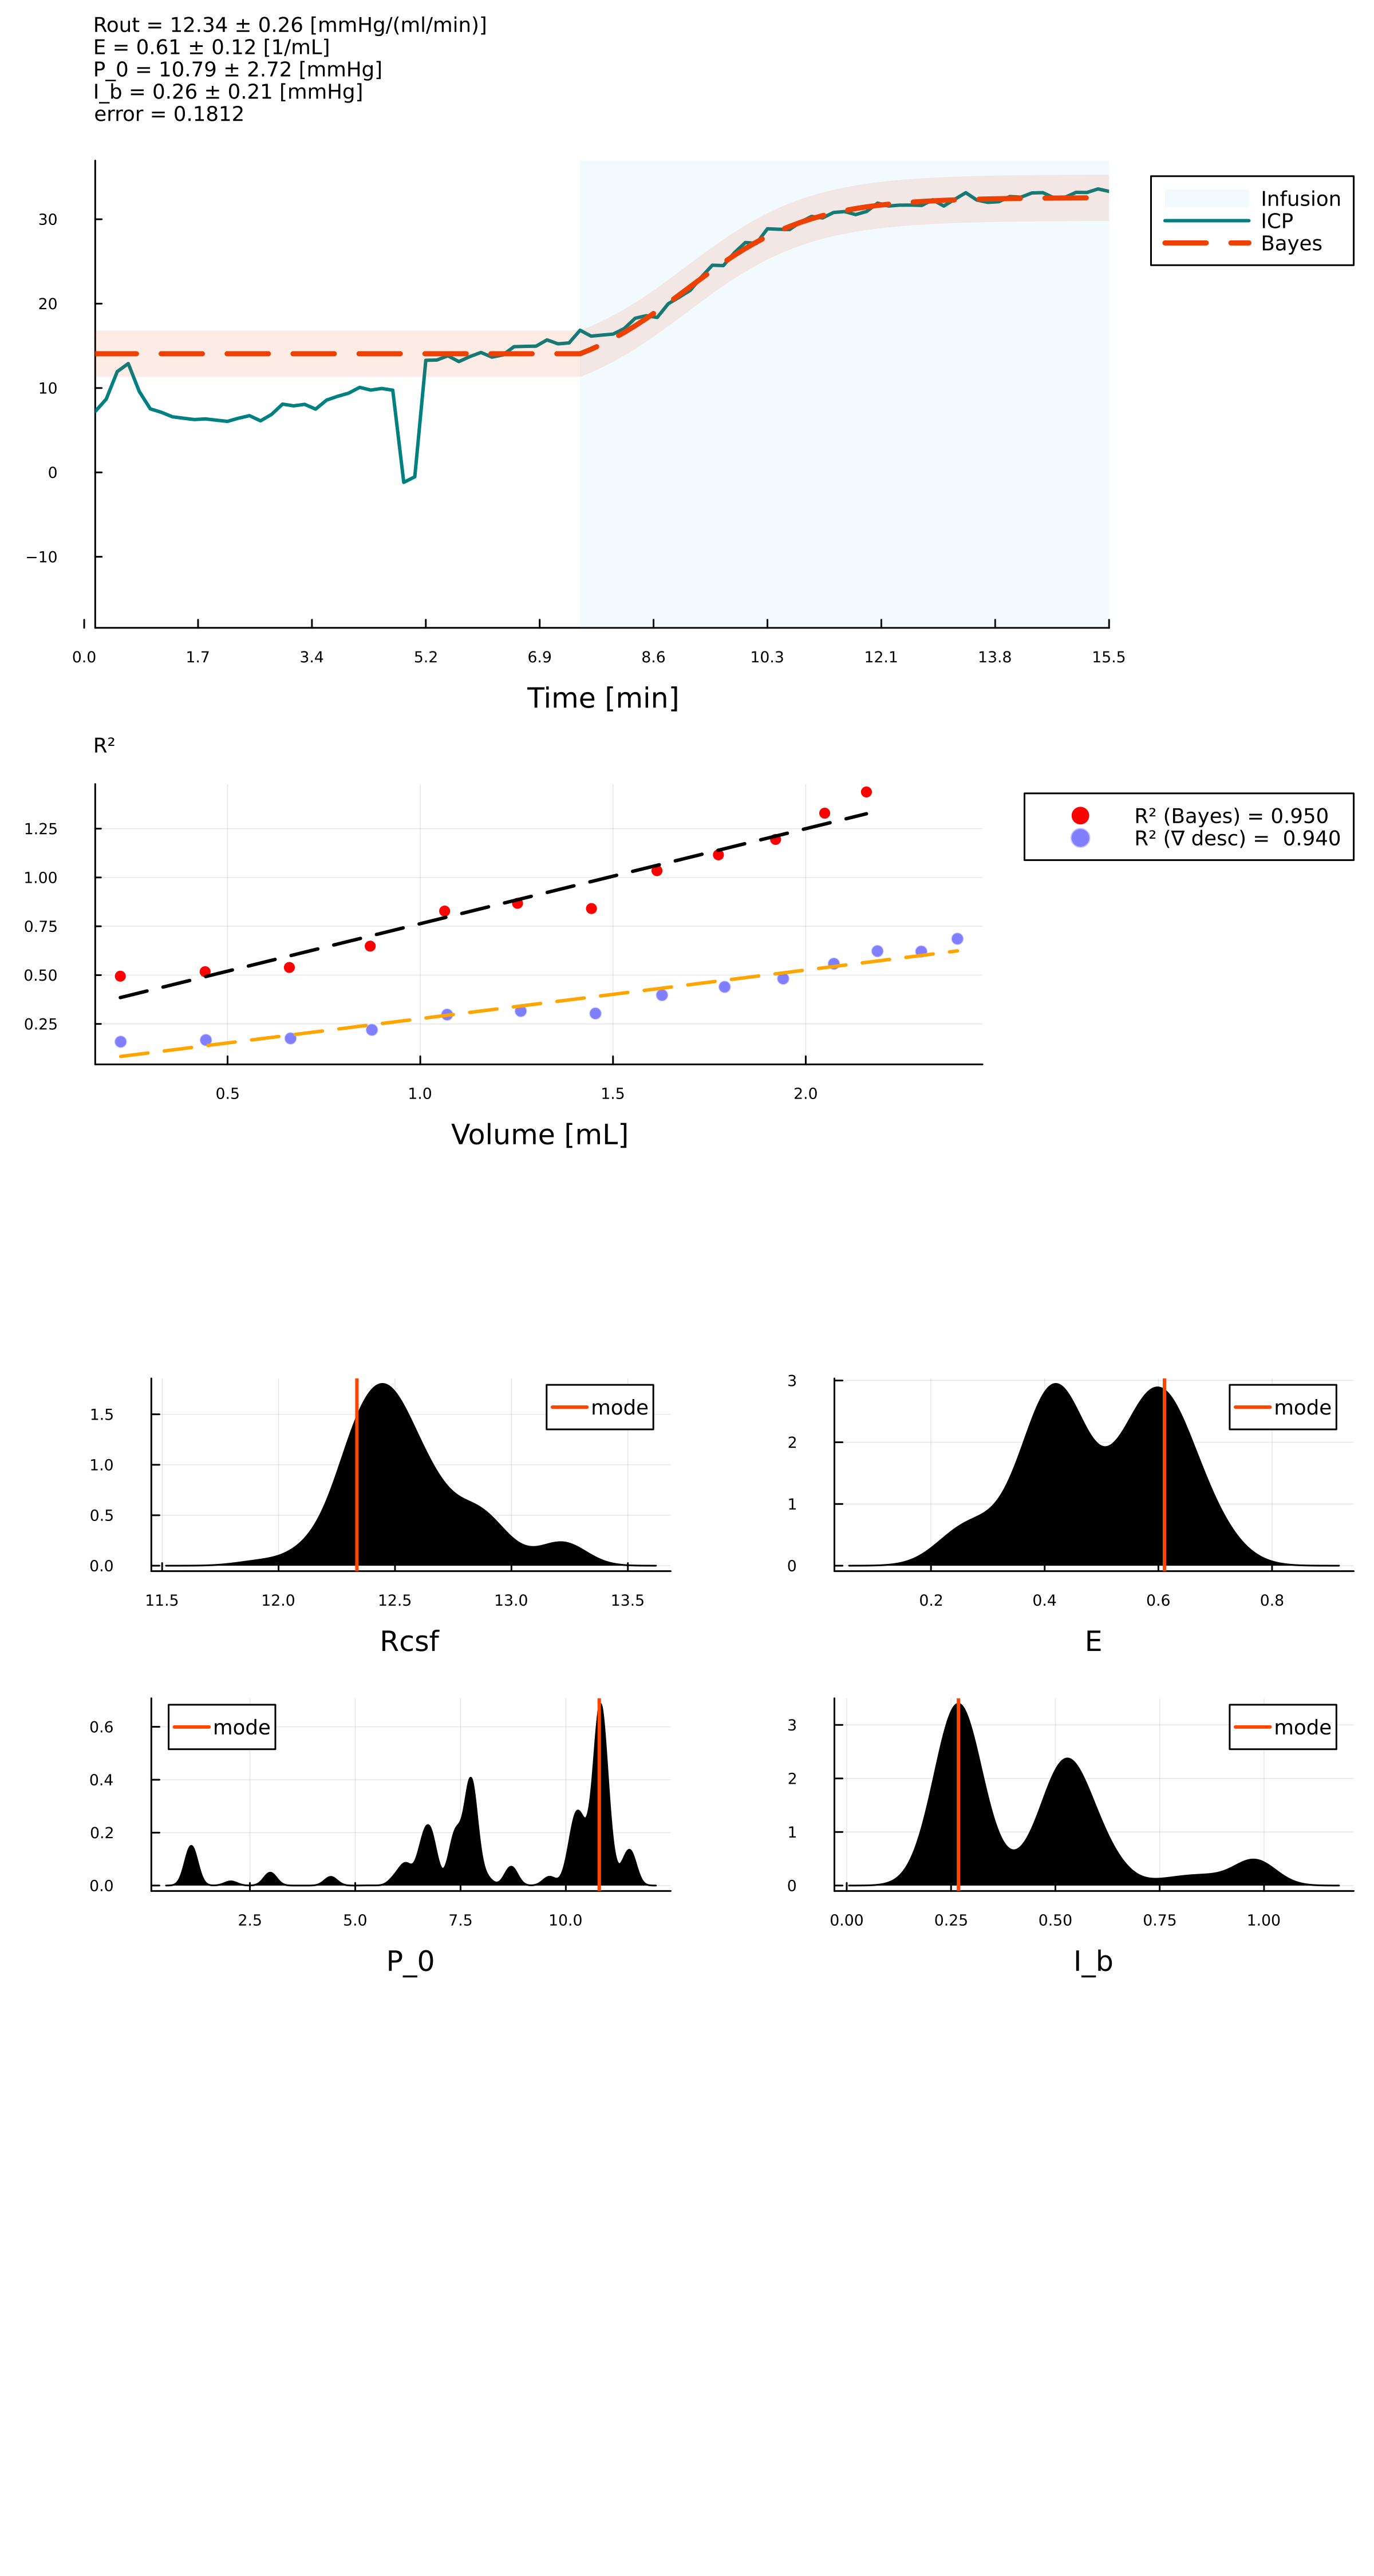

In [239]:
h1 = plotmodel(I_b, E, P_0, params_means, params_stddevs, "dar", "")

title!( @sprintf("Rout = %0.2f ± %0.2f [mmHg/(ml/min)]\n", params_modes[1], params_stddevs[1]) * 
        @sprintf("E = %0.2f ± %0.2f [1/mL]\n", params_modes[2], params_stddevs[2]) * 
        @sprintf("P_0 = %0.2f ± %0.2f [mmHg]\n", params_modes[3], params_stddevs[3]) *
        @sprintf("I_b = %0.2f ± %0.2f [mmHg]\n", I_b, std(Ib_chain)) *
        @sprintf("error = %0.4f \n", rmserr),
        titlealign=:left, titlefontsize=8, xlabel="Time [min]", ylabel="ICP [mmHg]")

R_bayes = Rcsf
R_icm = Data["Rcsf"]
P0_bayes = P_0
P0_icm = Data["P_0"]
nr=1

Pm = data;

bayescol=:red
icmcol=:blue
bgcolor=:white

volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(R_bayes[nr], P0_bayes[nr])
h2 = plot(volRes, log.(pressRes), seriestype=:scatter, makersize=5, color=bayescol, markerstrokewidth=0.5, markerstrokecolor=bgcolor, linewidth=1, label= @sprintf("R² (Bayes) = %.3f", R2), grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]")
plot!(volRes, fitted_curve, lw=2, linecolor=:black, linestyle=:dash, legend=:outertopright, label="")

volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(R_icm[nr], P0_icm[nr])
plot!(volRes, log.(pressRes), seriestype=:scatter, alpha=0.5, makersize=5, color=icmcol, markerstrokewidth=0.5, markerstrokecolor=bgcolor, linewidth=1, 
label="$(@sprintf("R² (∇ desc) =  %.3f", R2))", grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]")
plot!(volRes, fitted_curve, lw=2, linecolor=:orange, linestyle=:dash, legend=:outertopright, label="")
title!("R²")


bw = 0.05

kernd = kde(chain[:,1], bandwidth=bw*2)
h3 = plot(kernd, fillrange = zeros(length(kernd.density)), fillalpha = 1, c = "black", label="")
vline!(h3, [params_modes[1]], lw=2,label="mode", linecolor=:orangered, xlabel="Rcsf", ylabel="\n\n")

kernd = kde(chain[:,2], bandwidth=bw)
h4 = plot(kernd, fillrange = zeros(length(kernd.density)), fillalpha = 1, c = "black", label="")
vline!(h4, [params_modes[2]],lw=2,label="mode", linecolor=:orangered, xlabel="E", ylabel="\n\n")

kernd = kde(chain[:,3], bandwidth=bw*3)
h5 = plot(kernd, fillrange = zeros(length(kernd.density)), fillalpha = 1, c = "black", label="")
vline!(h5, [params_modes[3]],lw=2,label="mode", linecolor=:orangered, xlabel="P_0", ylabel="\n\n")
# vline!(h5, [Data["P_0"]], lw=2, label="static", linecolor=:teal)

kernd = kde(Ib_chain, bandwidth=bw)
h6 = plot(kernd, fillrange = zeros(length(kernd.density)), fillalpha = 1, c = "black", label="")
smooth_dist = kde(Ib_chain, bandwidth=0.05) # Mode is unstable if there are very small differences between values - smoothen
smooth_dist_vals = collect(smooth_dist.x)
Ib_mode = smooth_dist_vals[findmax(kernd.density)[2]]
vline!(h6, [Ib_mode],lw=2,label="mode", linecolor=:orangered, xlabel="I_b", ylabel="\n\n")


plot(h1, h2, h3, h4, h5, h6, layout=[grid(2,1, heights=[.5,.3]),grid(2,2, heights=[.2, .2, .2, .2])], size=(800,1500), dpi=300, tickfontsize=6)

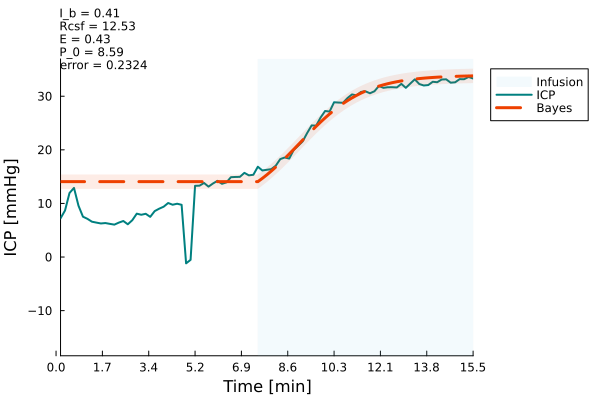

In [214]:
Pm = data;

pvout = press_vol_curve.(chain[1:100:end,1], chain[1:100:end,3])
cod = zeros(length(pvout))
for i = 1:length(pvout)
    cod[i] = pvout[i][4]
end

r2max = findmax(cod)[2]
I_b = (Data["P_b"] - chain[1:100:end,3][r2max])/chain[1:100:end,1][r2max]
E = chain[1:100:end,2][r2max]
P_0 = chain[1:100:end,3][r2max]
h1 = plotmodel(I_b, E, P_0, params_means, params_stddevs, "dar", "")

title!( @sprintf("Rout = %0.2f [mmHg/(ml/min)]\n", params_means[1]) * 
        @sprintf("I_b = %0.2f [mL/min]\n", params_means[2]) * 
        @sprintf("P_0 = %0.2f [mmHg]\n", params_means[3]) *
        @sprintf("error = %0.4f \n", rmserr),
        titlealign=:left, titlefontsize=8, xlabel="Time [min]", ylabel="ICP [mmHg]")



In [ ]:
title!( @sprintf("Rout = %0.2f ± %0.2f [mmHg/(ml/min)]\n", params_means[1], params_stddevs[1]) * 
        @sprintf("I_b = %0.2f ± %0.2f [mL/min]\n", params_means[2], params_stddevs[2]) * 
        @sprintf("P_0 = %0.2f ± %0.2f [mmHg]\n", params_means[3], params_stddevs[3]) *
        @sprintf("error = %0.4f \n", rmserr),
        titlealign=:left, titlefontsize=8, xlabel="Time [min]", ylabel="ICP [mmHg]")

R_bayes = Rcsf
R_icm = Data["Rcsf"]
P0_bayes = P_0
P0_icm = Data["P_0"]
nr=1

Pm = data;

bayescol=:red
icmcol=:blue
bgcolor=:white

volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(R_bayes[nr], P0_bayes[nr])
h2 = plot(volRes, log.(pressRes), seriestype=:scatter, makersize=5, color=bayescol, markerstrokewidth=0.5, markerstrokecolor=bgcolor, linewidth=1, label= @sprintf("R² (Bayes) = %.3f", R2), grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]")
plot!(volRes, fitted_curve, lw=2, linecolor=:black, linestyle=:dash, legend=:outertopright, label="")

volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(R_icm[nr], P0_icm[nr])
plot!(volRes, log.(pressRes), seriestype=:scatter, alpha=0.5, makersize=5, color=icmcol, markerstrokewidth=0.5, markerstrokecolor=bgcolor, linewidth=1, 
label="$(@sprintf("R² (∇ desc) =  %.3f", R2))", grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]")
plot!(volRes, fitted_curve, lw=2, linecolor=:orange, linestyle=:dash, legend=:outertopright, label="")
title!("R²")


bw = 0.05

kernd = kde(chain[:,1], bandwidth=bw*2)
h3 = plot(kernd, fillrange = zeros(length(kernd.density)), fillalpha = 1, c = "black", label="")
vline!(h3, [params_modes[1]], lw=2,label="mode", linecolor=:orangered, xlabel="Rcsf", ylabel="\n\n")

kernd = kde(chain[:,2], bandwidth=bw)
h4 = plot(kernd, fillrange = zeros(length(kernd.density)), fillalpha = 1, c = "black", label="")
vline!(h4, [params_modes[2]],lw=2,label="mode", linecolor=:orangered, xlabel="E", ylabel="\n\n")

kernd = kde(chain[:,3], bandwidth=bw*3)
h5 = plot(kernd, fillrange = zeros(length(kernd.density)), fillalpha = 1, c = "black", label="")
vline!(h5, [params_modes[3]],lw=2,label="mode", linecolor=:orangered, xlabel="P_0", ylabel="\n\n")
# vline!(h5, [Data["P_0"]], lw=2, label="static", linecolor=:teal)

kernd = kde(Ib_chain, bandwidth=bw)
h6 = plot(kernd, fillrange = zeros(length(kernd.density)), fillalpha = 1, c = "black", label="")
smooth_dist = kde(Ib_chain, bandwidth=0.05) # Mode is unstable if there are very small differences between values - smoothen
smooth_dist_vals = collect(smooth_dist.x)
Ib_mode = smooth_dist_vals[findmax(kernd.density)[2]]
vline!(h6, [Ib_mode],lw=2,label="mode", linecolor=:orangered, xlabel="I_b", ylabel="\n\n")


plot(h1, h2, h3, h4, h5, h6, layout=[grid(2,1, heights=[.5,.3]),grid(2,2, heights=[.2, .2, .2, .2])], size=(800,1500), dpi=300, tickfontsize=6)

In [ ]:
function scale_to_01(v::Vector)
    v_min = minimum(v)
    v_max = maximum(v)
    if v_min == v_max
        return fill(0.5, length(v))
    else
        return (v .- v_min) ./ (v_max - v_min)
    end
end

ch1 = scale_to_01(chain[:,1]./upperbound[1])
ch2 = scale_to_01(chain[:,2]./upperbound[2])
ch3 = scale_to_01(chain[:,3]./upperbound[3])

# plot([ch1[1:100:end] ch2[1:100:end] ch3[1:100:end]])
plot([chain[1:100:end,1]./upperbound[1], chain[1:100:end,2]./upperbound[2], chain[1:100:end,3]./upperbound[3]], ylim=[0,1])
hline!([mean(chain[:,1]./upperbound[1]), mean(chain[:,2]./upperbound[2]), mean(chain[:,3]./upperbound[3])], linewidth=2)